- 移动设备MAC地址 "3C:7D:0A:C0:68:AD"
- 三个无线网关地址
  - "14:6b:9c:f4:04:38" 坐标 (7,0)
  - "14:6b:9c:f4:03:f0" 坐标 (0,0)
  - "14:6b:9c:f4:04:16" 坐标 (6.5,3)

In [1]:
import math
import pymysql 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# 连接数据库
conn = pymysql.connect(host = '127.0.0.1', port = 3306, user = 'root', passwd = '123', charset = 'utf8')
cursor = conn.cursor()
cursor.execute('use ComNet;')

0

In [3]:
# 定义实际路由器坐标
x_router = [0, 7, 6.5]
y_router = [0, 0, 3]

In [4]:
# 从数据库中提取数据
# 数据集中 1-107为第一个点 108-234为第二个点 235-为第三个点
cursor.execute('select * from points where id <= 107;')
result1 = cursor.fetchall()
cursor.execute('select * from points where id > 107 and id <=234;')
result2 = cursor.fetchall()
cursor.execute('select * from points where id > 234;')
result3 = cursor.fetchall()

In [5]:
# 求来自某个路由器所有range值的平均值
def getAvgRange(Dict):
    sum = 0
    for i in Dict.values():
        sum += i
    return sum/len(Dict)


In [6]:
# 画图
def PictureGenerate(x_cal,y_cal,savepath):
    # 设置图像大小
    plt.figure(figsize=(10,5))

    # 绘制点
    x_dev = [5.5, 2, 3.7]
    y_dev = [0.6, 1, 2.1]
    plt.scatter(x_dev, y_dev, color='r',marker='1',label='Device')
    txt_dev = ['dev1','dev2','dev3']
    for i in range(len(x_dev)):
        plt.annotate(txt_dev[i], xy = (x_dev[i], y_dev[i]), xytext = (x_dev[i]+0.1, y_dev[i]-0.1))

    plt.scatter(x_router,y_router,color='springgreen',marker='D',label='Router')
    router_cal = ['router1','router2','router3']
    for i in range(len(x_cal)):
        plt.annotate(router_cal[i], xy = (x_router[i], y_router[i]), xytext = (x_router[i]+0.05, y_router[i]-0.1))

    plt.scatter(x_cal, y_cal, color='b',label='Calculated')
    txt_cal = ['cal1','cal2','cal3']
    for i in range(len(x_cal)):
        plt.annotate(txt_cal[i], xy = (x_cal[i], y_cal[i]), xytext = (x_cal[i]+0.05, y_cal[i]+0.1))

    # 设置坐标轴范围
    plt.xlim(-1, 8)
    plt.ylim(-1, 4)
    plt.title('graph of location')
    plt.legend()

    # 显示误差
    d1 = round(math.sqrt((x_dev[0] - x_cal[0])**2 + (y_dev[0] - y_cal[0])**2),2)
    text1 = 'd(dev1,cal1) = ' + str(d1)
    plt.text(-0.8, 3.8, text1)
    d2 = round(math.sqrt((x_dev[1] - x_cal[1])**2 + (y_dev[1] - y_cal[1])**2),2)
    text2 = 'd(dev2,cal2) = ' + str(d2)
    plt.text(-0.8, 3.5, text2)
    d3 = round(math.sqrt((x_dev[2] - x_cal[2])**2 + (y_dev[2] - y_cal[2])**2),2)
    text3 = 'd(dev3,cal3) = ' + str(d3)
    plt.text(-0.8, 3.2, text3)
    text4 = 'Average error = ' + str(round((d1+d2+d3)/3,2))
    plt.text(-0.8, 2.9, text4)

    # 保存图像
    plt.savefig(savepath)

    # 显示图形
    plt.show()


In [7]:
# 结果处理算法1: range 归一化方法
def resultProcessing1(result,x_table,y_table):

    # 使用range数据
    # 丢弃大于13的数据
    # 三个字典分别储存来自三个路由器的数据
    dict1,dict2,dict3 = {},{},{}
    for i in result:
        if i[5] < 13:
            if i[1] == '14:6b:9c:f4:03:f1':
                dict1[i[2][11:19]] = i[5]
            elif i[1] == '14:6b:9c:f4:04:17':
                dict2[i[2][11:19]] = i[5]
            else:
                dict3[i[2][11:19]] = i[5]

    # 计算每个路由器range平均值
    dis1 = getAvgRange(dict1)
    dis2 = getAvgRange(dict2)
    dis3 = getAvgRange(dict3)

    # 计算属于每个路由器坐标的权重
    weight1 = dis2*dis3/(dis1*dis2+dis2*dis3+dis3*dis1)
    weight2 = dis1*dis3/(dis1*dis2+dis2*dis3+dis3*dis1)
    weight3 = dis1*dis2/(dis1*dis2+dis2*dis3+dis3*dis1)

    # 按照权重加权路由器坐标得到计算的位置坐标
    x = x_router[0] * weight1 + x_router[2] * weight2 + x_router[1] * weight3
    y = y_router[0] * weight1 + y_router[2] * weight2 + y_router[1] * weight3

    # 将计算结果加入结果列表
    x_table.append(x)
    y_table.append(y)


In [8]:
# 结果处理算法2 rssi 归一化方法
def resultProcessing2(result,x_table,y_table):

    # 使用rssi数据
    # 丢弃大于13的数据
    # 参数调整后的rssi to distance 公式 dis = rssi ^ ((-53-rssi)/30)
    # 三个字典分别储存来自三个路由器的数据
    dict1,dict2,dict3 = {},{},{}
    for i in result:
        t = (pow(10,(-53-i[4])/30))
        if t < 13:
            if i[1] == '14:6b:9c:f4:03:f1':
                dict1[i[2][11:19]] = t
            elif i[1] == '14:6b:9c:f4:04:17':
                dict2[i[2][11:19]] = t
            else:
                dict3[i[2][11:19]] = t

    # 计算每个路由器distance平均值
    dis1 = getAvgRange(dict1)
    dis2 = getAvgRange(dict2)
    dis3 = getAvgRange(dict3)

    # 计算属于每个路由器坐标的权重
    weight1 = dis2*dis3/(dis1*dis2+dis2*dis3+dis3*dis1)
    weight2 = dis1*dis3/(dis1*dis2+dis2*dis3+dis3*dis1)
    weight3 = dis1*dis2/(dis1*dis2+dis2*dis3+dis3*dis1)

    # 按照权重加权路由器坐标得到计算的位置坐标
    x = 0 * weight1 + 6.5 * weight2 + 7 * weight3
    y = 0 * weight1 + 3 * weight2 + 0 * weight3

    # 将计算结果加入结果列表
    x_table.append(x)
    y_table.append(y)
    

In [9]:
# 结果处理算法3 range几何平均法
def resultProcessing3(result,x_table,y_table):

    # 使用range数据
    # 丢弃大于13的数据
    # 三个字典分别储存来自三个路由器的数据
    dict1,dict2,dict3 = {},{},{}
    for i in result:
        if i[5] < 13:
            if i[1] == '14:6b:9c:f4:03:f1':
                dict1[i[2][11:19]] = i[5]
            elif i[1] == '14:6b:9c:f4:04:17':
                dict2[i[2][11:19]] = i[5]
            else:
                dict3[i[2][11:19]] = i[5]

    # 计算每个路由器range平均值
    dis1 = getAvgRange(dict1)
    dis2 = getAvgRange(dict2)
    dis3 = getAvgRange(dict3)

    # 算出距离两路由器长度和
    sum12 = dis1+dis2
    sum13 = dis1+dis3
    sum23 = dis2+dis3

    # 计算出路由器三角形三边长度
    d12 = math.sqrt((x_router[1]-x_router[0])**2 + (y_router[1]-y_router[0])**2)
    d13 = math.sqrt((x_router[2]-x_router[0])**2 + (y_router[2]-y_router[0])**2)
    d23 = math.sqrt((x_router[2]-x_router[1])**2 + (y_router[2]-y_router[1])**2)

    # 计算出两圆交点中点与该边端点的距离
    p12 = d12/2 + ((dis1**2 - dis2**2)/(2*d12))
    p13 = d13/2 + ((dis1**2 - dis3**2)/(2*d13))
    p23 = d23/2 + ((dis2**2 - dis3**2)/(2*d23))

    # 如果数据合适就使用两圆交点中点与该边端点的距离
    # 否则使用距离两路由器长度的比值
    if (sum12 < d12) or (dis1 > d12) or (dis2 > d12):
        x12 = x_router[0] + (x_router[1]-x_router[0])*dis1/sum12
        y12 = y_router[0] + (y_router[1]-y_router[0])*dis1/sum12
    else:
        x12 = x_router[0] + (x_router[1]-x_router[0])*p12/d12
        y12 = y_router[0] + (y_router[1]-y_router[0])*p12/d12 

    if (sum13 < d13) or (dis1 > d13) or (dis3 > d13):
        x13 = x_router[0] + (x_router[2]-x_router[0])*dis1/sum13
        y13 = y_router[0] + (y_router[2]-y_router[0])*dis1/sum13
    else:
        x13 = x_router[0] + (x_router[2]-x_router[0])*p13/d13
        y13 = y_router[0] + (y_router[2]-y_router[0])*p13/d13
        
    if (sum23 < d23) or (dis2 > d23) or (dis3 > d23):
        x23 = x_router[1] + (x_router[2]-x_router[1])*dis2/sum23
        y23 = y_router[1] + (y_router[2]-y_router[1])*dis2/sum23
    else:
        x23 = x_router[1] + (x_router[2]-x_router[1])*p23/d23
        y23 = y_router[1] + (y_router[2]-y_router[1])*p23/d23

    # 将求出的三个点坐标做平均  
    x = (x12 + x13 + x23)/3
    y = (y12 + y13 + y23)/3

    # 将计算结果加入结果列表
    x_table.append(x)
    y_table.append(y)

In [10]:
# 结果处理算法4 rssi几何平均法
def resultProcessing4(result,x_table,y_table):

    # 使用rssi数据
    # 丢弃大于13的数据
    # 参数调整后的rssi to distance 公式 dis = rssi ^ ((-53-rssi)/30)
    # 三个字典分别储存来自三个路由器的数据
    dict1,dict2,dict3 = {},{},{}
    for i in result:
        t = (pow(10,(-53-i[4])/30))
        if t < 13:
            if i[1] == '14:6b:9c:f4:03:f1':
                dict1[i[2][11:19]] = t
            elif i[1] == '14:6b:9c:f4:04:17':
                dict2[i[2][11:19]] = t
            else:
                dict3[i[2][11:19]] = t

    # 计算每个路由器range平均值
    dis1 = getAvgRange(dict1)
    dis2 = getAvgRange(dict2)
    dis3 = getAvgRange(dict3)

    # 算出距离两路由器长度和
    sum12 = dis1+dis2
    sum13 = dis1+dis3
    sum23 = dis2+dis3

    # 计算出路由器三角形三边长度
    d12 = math.sqrt((x_router[1]-x_router[0])**2 + (y_router[1]-y_router[0])**2)
    d13 = math.sqrt((x_router[2]-x_router[0])**2 + (y_router[2]-y_router[0])**2)
    d23 = math.sqrt((x_router[2]-x_router[1])**2 + (y_router[2]-y_router[1])**2)

    # 计算出两圆交点中点与该边端点的距离
    p12 = d12/2 + ((dis1**2 - dis2**2)/(2*d12))
    p13 = d13/2 + ((dis1**2 - dis3**2)/(2*d13))
    p23 = d23/2 + ((dis2**2 - dis3**2)/(2*d23))

    # 如果数据合适就使用两圆交点中点与该边端点的距离
    # 否则使用距离两路由器长度的比值
    if (sum12 < d12) or (dis1 > d12) or (dis2 > d12):
        x12 = x_router[0] + (x_router[1]-x_router[0])*dis1/sum12
        y12 = y_router[0] + (y_router[1]-y_router[0])*dis1/sum12
    else:
        x12 = x_router[0] + (x_router[1]-x_router[0])*p12/d12
        y12 = y_router[0] + (y_router[1]-y_router[0])*p12/d12 

    if (sum13 < d13) or (dis1 > d13) or (dis3 > d13):
        x13 = x_router[0] + (x_router[2]-x_router[0])*dis1/sum13
        y13 = y_router[0] + (y_router[2]-y_router[0])*dis1/sum13
    else:
        x13 = x_router[0] + (x_router[2]-x_router[0])*p13/d13
        y13 = y_router[0] + (y_router[2]-y_router[0])*p13/d13
        
    if (sum23 < d23) or (dis2 > d23) or (dis3 > d23):
        x23 = x_router[1] + (x_router[2]-x_router[1])*dis2/sum23
        y23 = y_router[1] + (y_router[2]-y_router[1])*dis2/sum23
    else:
        x23 = x_router[1] + (x_router[2]-x_router[1])*p23/d23
        y23 = y_router[1] + (y_router[2]-y_router[1])*p23/d23

    # 将求出的三个点坐标做平均  
    x = (x12 + x13 + x23)/3
    y = (y12 + y13 + y23)/3

    # 将计算结果加入结果列表
    x_table.append(x)
    y_table.append(y)

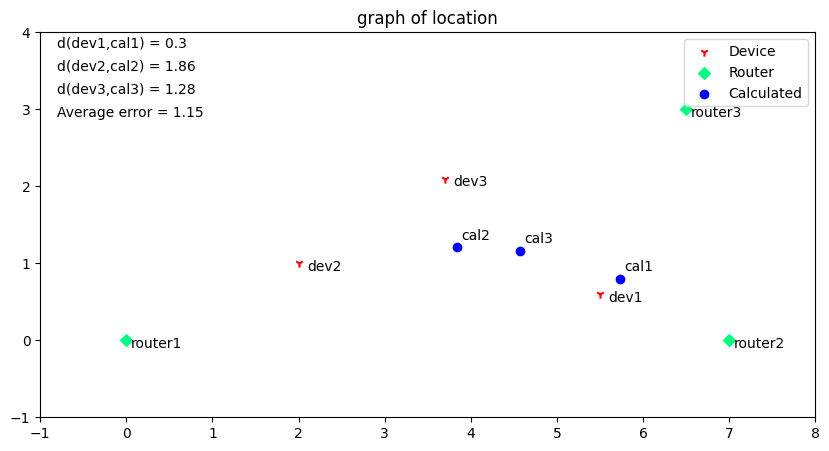

In [11]:
# 创建结果列表 处理结果

x_cal = []
y_cal = []

resultProcessing1(result1,x_cal,y_cal)
resultProcessing1(result2,x_cal,y_cal)
resultProcessing1(result3,x_cal,y_cal)
PictureGenerate(x_cal,y_cal,'./graph1.jpg')

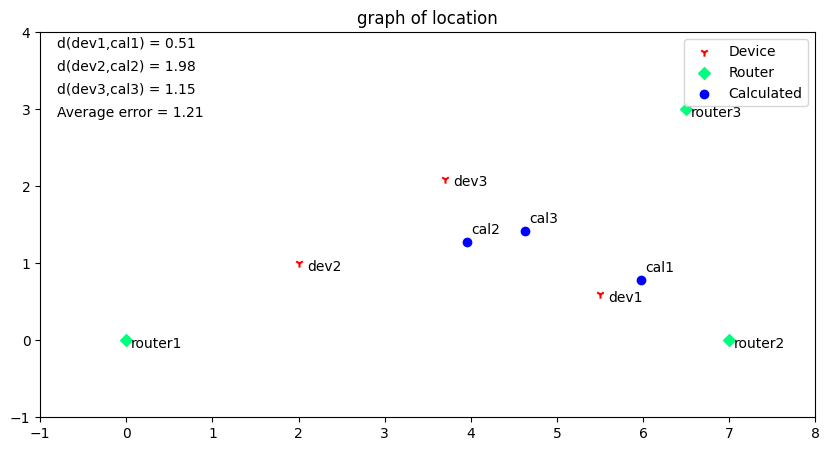

In [12]:
# 创建结果列表 处理结果

x_cal = []
y_cal = []

resultProcessing2(result1,x_cal,y_cal)
resultProcessing2(result2,x_cal,y_cal)
resultProcessing2(result3,x_cal,y_cal)
PictureGenerate(x_cal,y_cal,'./graph2.jpg')

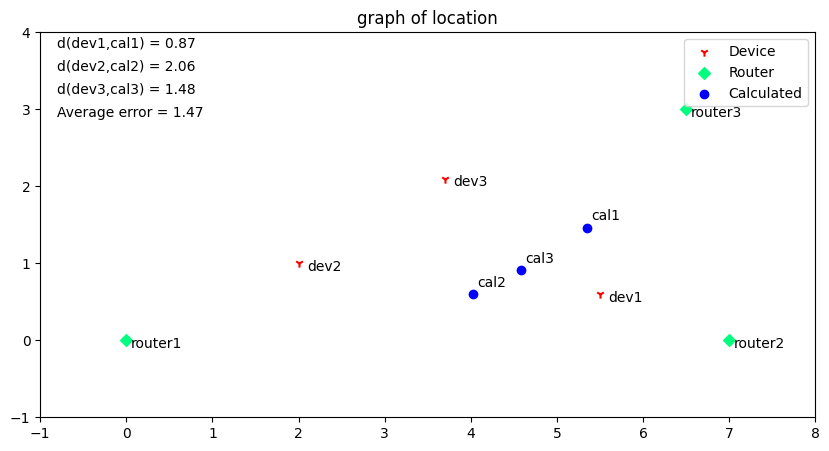

In [13]:
# 创建结果列表 处理结果

x_cal = []
y_cal = []

resultProcessing3(result1,x_cal,y_cal)
resultProcessing3(result2,x_cal,y_cal)
resultProcessing3(result3,x_cal,y_cal)
PictureGenerate(x_cal,y_cal,'./graph3.jpg')

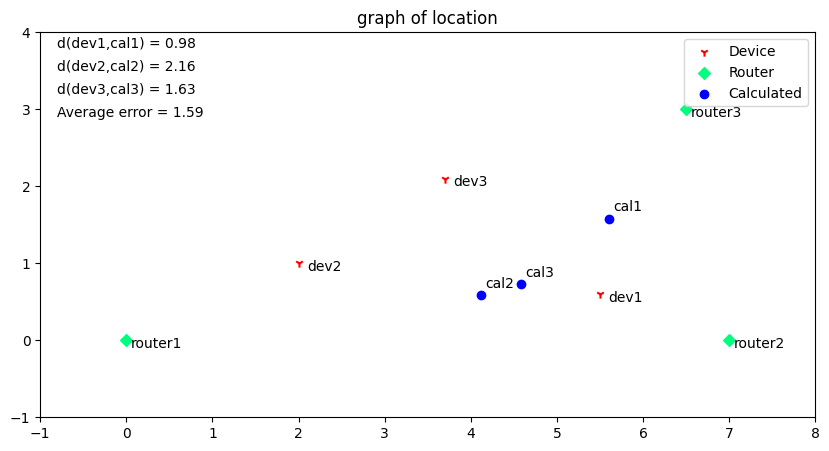

In [14]:
# 创建结果列表 处理结果

x_cal = []
y_cal = []

resultProcessing4(result1,x_cal,y_cal)
resultProcessing4(result2,x_cal,y_cal)
resultProcessing4(result3,x_cal,y_cal)
PictureGenerate(x_cal,y_cal,'./graph4.jpg')